In [2]:
import seaborn as sns
sns.set(rc={'axes.facecolor': 'dimgrey', 'grid.color': 'lightgrey'})
import pandas as pd
import torch
import copy
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.explain.metric import fidelity
from torch_geometric.explain import ModelConfig, ExplainerConfig, GNNExplainer
from torch_geometric.explain import Explainer
from torch_geometric.loader import NeighborLoader

In [3]:
%run utils.ipynb
%run gcn_model.ipynb
%run GAT_model.ipynb

In [4]:
# class 1 is illicit, 2 is licit, unknown is unknown
labels = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
nodes = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [5]:
indexes = labels.index[labels["class"] != "unknown"].tolist()
new_labels = labels.replace("unknown", 3)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
data, graph_info = create_graph(nodes, edges, new_labels, device)
data

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769])

In [8]:
# generate test and train masks
train_p = 0.8
# indices of the illicit and licit transaction nodes
illicit_idx = (data.y == 0).nonzero(as_tuple=True)[0]
# Generate random permutation of indices
illicit_train, illicit_test = torch.utils.data.random_split(illicit_idx, lengths=[train_p, (1-train_p)])

# the same for the licit nodes
licit_idx   = (data.y == 1).nonzero(as_tuple=True)[0]
licit_train, licit_test = torch.utils.data.random_split(licit_idx, lengths=[train_p, (1-train_p)])
# obtain the training and test "masks", i.e. indices for the train and test sets
unlabelled_idx = (data.y == 2).nonzero(as_tuple=True)[0]
unlabelled_train, unlabelled_test = torch.utils.data.random_split(unlabelled_idx, lengths=[train_p, (1-train_p)])


train_mask = torch.cat([torch.tensor(illicit_train), torch.tensor(licit_train)])
test_mask  = torch.cat([torch.tensor(illicit_test), torch.tensor(licit_test)])

train_mask.shape, test_mask.shape

(torch.Size([37253]), torch.Size([9311]))

In [9]:
from torch_geometric.loader import ClusterLoader, RandomNodeLoader, ImbalancedSampler
# from torch_geometric.data import ClusterData
# train_loader = NeighborLoader(
#     data,
#     input_nodes=train_mask,
#     num_neighbors=[-1],
#     batch_size=2048,
# )
#
# test_loader = NeighborLoader(
#     data,
#     input_nodes=test_mask,
#     num_neighbors=[-1],
#     batch_size=2048,
# )
sampler = ImbalancedSampler(data, input_nodes=train_mask)
test_sampler = ImbalancedSampler(data, input_nodes=test_mask)
train_loader = NeighborLoader(data,
                        batch_size=1024, num_neighbors=[20, 1],
                        sampler=sampler,input_nodes=train_mask)

test_loader = NeighborLoader(data,
                              batch_size=1024, num_neighbors=[20, 1],
                              sampler=test_sampler,input_nodes=test_mask)
for b in train_loader:
    print((b.y == 0).sum(),(b.y == 1).sum(),(b.y == 2).sum())
    break

tensor(644, device='cuda:0') tensor(1129, device='cuda:0') tensor(946, device='cuda:0')


In [17]:
GCN = GNN_Example(node_dim=data.x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

In [18]:
lr = 1e-3
epochs = 200
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GCN.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_test_loss = 1e10
best_result = None
train_losses = []
test_losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GCN, train_loader,train_mask, optimizer, loss_fn, device)
    train_losses.append(loss)
    result, test_loss = test(GCN, test_loader,loss_fn,test_mask, device)
    test_losses.append(test_loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = copy.deepcopy(GCN)
        best_result = result
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        for item, amount in result.items():
                print("{} ({})".format(item, amount))
        print("############################")
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "gcn.pt")
print(best_result)

Epoch:  10
0 ({'precision': 0.7321428571428571, 'recall': 0.7321428571428571, 'f1-score': 0.7321428571428571, 'support': 56})
1 ({'precision': 0.8770491803278688, 'recall': 0.8770491803278688, 'f1-score': 0.8770491803278688, 'support': 122})
accuracy (0.8314606741573034)
macro avg ({'precision': 0.8045960187353629, 'recall': 0.8045960187353629, 'f1-score': 0.8045960187353629, 'support': 178})
weighted avg ({'precision': 0.8314606741573034, 'recall': 0.8314606741573034, 'f1-score': 0.8314606741573034, 'support': 178})
############################
Epoch:  20
0 ({'precision': 0.7833333333333333, 'recall': 0.8703703703703703, 'f1-score': 0.8245614035087719, 'support': 54})
1 ({'precision': 0.9457364341085271, 'recall': 0.9037037037037037, 'f1-score': 0.9242424242424242, 'support': 135})
accuracy (0.8941798941798942)
macro avg ({'precision': 0.8645348837209302, 'recall': 0.8870370370370371, 'f1-score': 0.8744019138755981, 'support': 189})
weighted avg ({'precision': 0.8993355481727575, 'rec

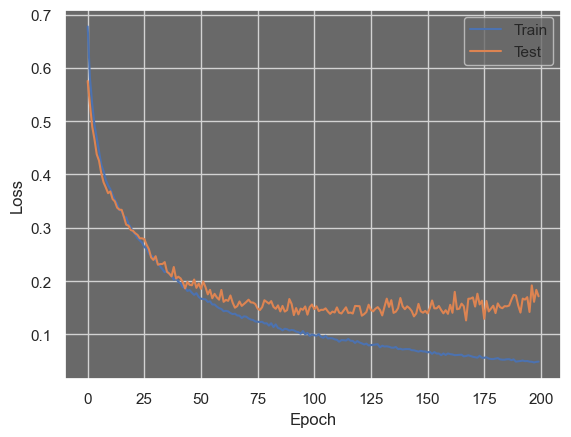

In [16]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [12]:
# class 1 lict
# class 0 ilicit
c, w = get_ilicit_predictions(GCN, test_loader, test_mask, device)
c, w = c[0], w[0]
print(c.shape, w.shape)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# node_index =[8440, 8716, 8728, 8734, 8757, 8760, 8762, 8763, 8765, 8773, 8776, 8808]
#[8041, 8107, 8157, 8170, 8368, 8394, 8415, 8439, 8440, 8455, 8493, 8496, 8530, 8567, 8568, 8579, 8590, 8594, 8612, 8624, 8657, 8674, 8687, 8696, 8716, 8728, 8734, 8757, 8760, 8762, 8763, 8765, 8773, 8776, 8808, 8814, 8819, 8827, 8845, 8846, 8856, 8874, 8882, 8900, 8902, 8912, 8915, 8921, 8946, 8986, 8987] #illicit_idx[:200].tolist()
explainer = Explainer(
    model=GCN,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    )
)
explanation_correct = explainer(data.x, data.edge_index, index=c)
explanation_wrong = explainer(data.x, data.edge_index, index=w)

In [ ]:
fid_pm = fidelity(explainer, explanation_correct)
print(fid_pm)
explanation_correct.visualize_graph('pics/subgraph_correct.png', backend="networkx")


fid_pm = fidelity(explainer, explanation_wrong)
print(fid_pm)
explanation_wrong.visualize_graph('pics/subgraph_wrong.png', backend="networkx")

In [ ]:
import networkx as nx
# add cycle find
index  = 10
edge_list = data.edge_index.cpu().detach().numpy()
G = nx.from_edgelist(edge_list.T)
ns = G.neighbors(c[index])
nodes = []
for n in ns:
    nodes.append(n)
nodes.append(c[index])
cliques = nx.algorithms.clique.cliques_containing_node(G, nodes)

D = nx.DiGraph()
for clique in cliques.values():
    for edge in clique:
        D.add_edge(edge[0], edge[1])
print(c[index], G.degree(c[index]))

plt.figure(1, figsize=(20,20))
nx.draw_networkx(D, node_size=400)
plt.show()

cycles = nx.find_cycle(G, c[index])


In [ ]:
index  = 5
G = nx.from_edgelist(edge_list.T)
ns = G.neighbors(w[index])
nodes = []
for n in ns:
    nodes.append(n)
nodes.append(w[index])
cliques = nx.algorithms.clique.cliques_containing_node(G, nodes)

D = nx.DiGraph()
for clique in cliques.values():
    for edge in clique:
        D.add_edge(edge[0], edge[1])

print(w[index], G.degree(w[index]))
plt.figure(1, figsize=(20,20))
nx.draw_networkx(D, node_size=600)
plt.show()

In [ ]:
import numpy as np

degree_correct = []
degree_wrong = []
for node in c:
    try:
        degree_correct.append(G.degree(node))
    except:
        continue
for node in w:
    try:
        degree_wrong.append(G.degree(node))
    except:
        continue
print(np.mean(degree_correct), np.std(degree_correct), len(degree_correct))
print(np.mean(degree_wrong),np.std(degree_wrong), len(degree_wrong))

normalized_correct = (np.array(degree_correct) - np.mean(degree_correct)) / np.std(degree_correct)
normalized_wrong = (np.array(degree_wrong) - np.mean(degree_wrong)) / np.std(degree_wrong)

plt.scatter(np.arange(len(degree_correct)), normalized_correct, label="Correctly classfied")
plt.scatter(np.arange(len(degree_wrong)), normalized_wrong, label="Wrongly Classfied")
plt.legend()
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu, ttest_ind, wilcoxon, ks_2samp

U1, p = mannwhitneyu(degree_correct, degree_wrong, method="auto",  alternative="two-sided")
print(U1, p)

res = ks_2samp(degree_correct, degree_wrong)
print(res)

In [9]:
%run GAT_model.ipynb
GAT = GraphAttentionNetwork(node_dim=data.x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=3, heads=2, dropout_rate=0.1).to(device)

In [10]:
lr = 1e-3
epochs = 200
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GAT.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []
best_test_loss = 1e9

for epoch in range(1, 1 + epochs):
    # train with random split
    train_losses = []
test_losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GAT, train_loader,train_mask, optimizer, loss_fn, device)
    train_losses.append(loss)
    result, test_loss = test(GAT, test_loader,loss_fn,test_mask, device)
    test_losses.append(test_loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = copy.deepcopy(GAT)
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        for item, amount in result.items():
                print("{} ({})".format(item, amount))
        print("############################")
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "gat.pt")

Epoch:  10
0 ({'precision': 0.7333333333333333, 'recall': 0.9166666666666666, 'f1-score': 0.8148148148148148, 'support': 60})
1 ({'precision': 0.9456521739130435, 'recall': 0.8130841121495327, 'f1-score': 0.8743718592964823, 'support': 107})
accuracy (0.8502994011976048)
macro avg ({'precision': 0.8394927536231884, 'recall': 0.8648753894080996, 'f1-score': 0.8445933370556485, 'support': 167})
weighted avg ({'precision': 0.8693699557406925, 'recall': 0.8502994011976048, 'f1-score': 0.8529741187641467, 'support': 167})
############################
Epoch:  20
0 ({'precision': 0.64, 'recall': 0.8275862068965517, 'f1-score': 0.7218045112781956, 'support': 58})
1 ({'precision': 0.9038461538461539, 'recall': 0.7768595041322314, 'f1-score': 0.8355555555555555, 'support': 121})
accuracy (0.7932960893854749)
macro avg ({'precision': 0.7719230769230769, 'recall': 0.8022228555143915, 'f1-score': 0.7786800334168755, 'support': 179})
weighted avg ({'precision': 0.8183541039965622, 'recall': 0.793296

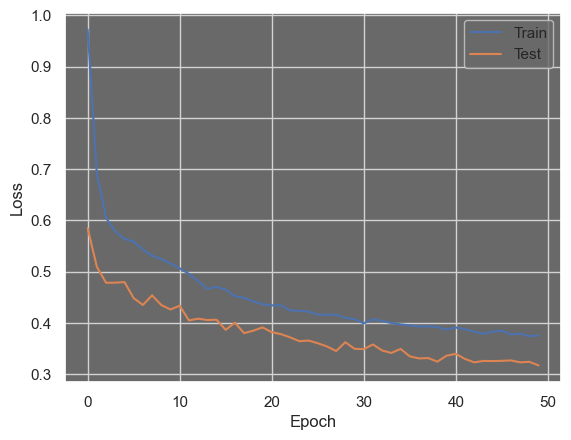

In [11]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# class 1 lict
# class 0 ilicit
c, w = get_ilicit_predictions(GAT, loader, test_mask, device)
c, w = c[0], w[0]
print(c.shape, w.shape)

In [ ]:
explainer = Explainer(
    model=GAT,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    )
)
explanation_correct = explainer(data.x, data.edge_index, index=c)
explanation_wrong = explainer(data.x, data.edge_index, index=w)

In [ ]:
fid_pm = fidelity(explainer, explanation_correct)
print(fid_pm)
explanation_correct.visualize_graph('subgraph_correct.png', backend="networkx")


fid_pm = fidelity(explainer, explanation_wrong)
print(fid_pm)
explanation_wrong.visualize_graph('subgraph_wrong.png', backend="networkx")

In [ ]:
import numpy as np

degree_correct = []
degree_wrong = []
for node in c:
    try:
        degree_correct.append(G.degree(node))
    except:
        continue
for node in w:
    try:
        degree_wrong.append(G.degree(node))
    except:
        continue
print(np.mean(degree_correct), np.std(degree_correct), len(degree_correct))
print(np.mean(degree_wrong),np.std(degree_wrong), len(degree_wrong))

normalized_correct = (np.array(degree_correct) - np.mean(degree_correct)) / np.std(degree_correct)
normalized_wrong = (np.array(degree_wrong) - np.mean(degree_wrong)) / np.std(degree_wrong)

plt.scatter(np.arange(len(degree_correct)), normalized_correct, label="Correctly classfied")
plt.scatter(np.arange(len(degree_wrong)), normalized_wrong, label="Wrongly Classfied")
plt.legend()
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu, ks_2samp

U1, p = mannwhitneyu(degree_correct, degree_wrong, method="auto",  alternative="two-sided")
print(U1, p)

res = ks_2samp(degree_correct, degree_wrong)
print(res)

In [ ]:
from sklearn.manifold import TSNE

untrained_gat = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)

# Get embeddings
h = untrained_gat(data["train"][0])

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
            init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data["train"][0].y)
plt.show()

In [ ]:
# Get embeddings
checkpoint = torch.load("gat.pt", map_location=device)
GAT = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)
GAT.load_state_dict(checkpoint["net"])

h = GAT(data["train"][0])

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
            init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data["train"][0].y)
plt.show()

In [12]:
%run FeatureAggregationModel.ipynb
SFA = SpatialFeatureAggregator(node_dim=data.x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

In [1]:
lr = 1e-3
epochs = 200
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(SFA.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []
best_test_loss = 1e9

for epoch in range(1, 1 + epochs):
    # train with random split
    train_losses = []
test_losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(SFA, train_loader,train_mask, optimizer, loss_fn, device)
    train_losses.append(loss)
    result, test_loss = test(SFA, test_loader,loss_fn,test_mask, device)
    test_losses.append(test_loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = copy.deepcopy(SFA)
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        for item, amount in result.items():
                print("{} ({})".format(item, amount))
        print("############################")
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "SFA.pt")

NameError: name 'torch' is not defined

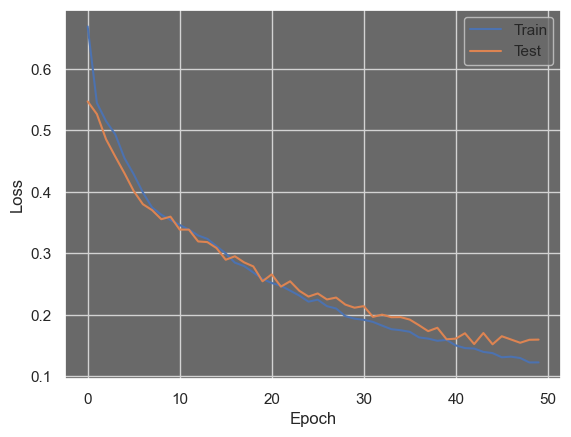

In [15]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [16]:
%run LSTM_GNN.ipynb
TB = TemporalBoy(node_dim=data.x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

D:\Python\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [17]:
lr = 1e-3
epochs = 200
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(TB.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []
best_test_loss = 1e9

for epoch in range(1, 1 + epochs):
    # train with random split
    train_losses = []
test_losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(TB, train_loader,train_mask, optimizer, loss_fn, device)
    train_losses.append(loss)
    result, test_loss = test(TB, test_loader,loss_fn,test_mask, device)
    test_losses.append(test_loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = copy.deepcopy(TB)
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        for item, amount in result.items():
                print("{} ({})".format(item, amount))
        print("############################")
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "TB.pt")

Epoch:  10
0 ({'precision': 0.7209302325581395, 'recall': 0.5961538461538461, 'f1-score': 0.6526315789473683, 'support': 52})
1 ({'precision': 0.8278688524590164, 'recall': 0.8938053097345132, 'f1-score': 0.8595744680851064, 'support': 113})
accuracy (0.8)
macro avg ({'precision': 0.7743995425085779, 'recall': 0.7449795779441797, 'f1-score': 0.7561030235162374, 'support': 165})
weighted avg ({'precision': 0.794166984369043, 'recall': 0.8, 'f1-score': 0.7943561030235163, 'support': 165})
############################
Epoch:  20
0 ({'precision': 0.8153846153846154, 'recall': 0.8412698412698413, 'f1-score': 0.8281250000000001, 'support': 63})
1 ({'precision': 0.9130434782608695, 'recall': 0.8974358974358975, 'f1-score': 0.9051724137931034, 'support': 117})
accuracy (0.8777777777777778)
macro avg ({'precision': 0.8642140468227424, 'recall': 0.8693528693528694, 'f1-score': 0.8666487068965518, 'support': 180})
weighted avg ({'precision': 0.8788628762541805, 'recall': 0.8777777777777778, 'f1-s

In [ ]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()